# Pokemon Regionals Statistics
### This notebook ingests and runs statistics on a json dump from pokedata.ovh, intended for use in tournament prep

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from matplotlib.colors import LinearSegmentedColormap
import pickle

### Import JSON

In [2]:
def ingest_json(file_path):
    """
    Reads and ingests a JSON file.

    Args:
        file_path (str): The path to the JSON file.

    Returns:
        dict: Parsed JSON data as a dictionary.
    """
    try:
        with open(file_path, 'r') as file:
            data = json.load(file)  # Parse the JSON file
            return data
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
    except json.JSONDecodeError as e:
        print(f"Error: Failed to decode JSON file. {e}")

In [3]:
tournament_json_parent_dir = './tournaments/'
tournament_names = ['stuttgart', 'toronto', 'sacramento','perth','bogota']

In [4]:
# Add "- TournamentName" to all player names so that multiple tournaments can be run at once
all_players = []
for tournament in tournament_names:
    file_path = tournament_json_parent_dir+tournament+".json"  # Replace with your JSON file path
    players = ingest_json(file_path)
    for i in range(len(players)):
        players[i]['name']=players[i]['name']+'-'+tournament
        for round_num in players[i]['rounds'].keys():
            players[i]['rounds'][round_num]['name'] = players[i]['rounds'][round_num]['name']+'-'+tournament
    all_players.extend(players)

In [5]:
len(all_players)

6087

### Pickle methods

In [6]:
def dump_dict_to_file(dictionary, filename):
    """
    Dumps a dictionary to a file using pickle.
    
    Parameters:
        dictionary (dict): The dictionary to save.
        filename (str): The path of the file where the dictionary will be saved.
    """
    with open(filename, 'wb') as file:
        pickle.dump(dictionary, file)

def read_dict_from_file(filename):
    """
    Reads a dictionary from a file using pickle.
    
    Parameters:
        filename (str): The path of the file to read the dictionary from.
    
    Returns:
        dict: The dictionary read from the file.
    """
    with open(filename, 'rb') as file:
        dictionary = pickle.load(file)
    return dictionary


### Deck Categorization Rules

In [7]:
'''
this is the dict that decides what a deck is. to be 'Name', it will need
all of the listed cards in at least their listed counts.

These logics will be executed in order listed, so DO THINGS LIKE PULT-THORNS
BEFORE PULT OR THORNS, otherwise a pult-thorns may be classified as pult
before getting to the pult-thorns logic

TODO: fix issue of decks belonging to multiple names
'''
deck_rules = {
    'Regidrago': {'Regidrago V':3},
    'Charizard': {'Charizard ex':2},
    'Lugia': {'Lugia V':3},
    'Gardevoir': {'Gardevoir ex':2},
    'Pult-Thorns':{'Dragapult ex':2,'Iron Thorns ex':2},
    'Dragapult': {'Dreepy':3},
    'Iron Thorns': {'Iron Thorns ex':2},
    'Raging Bolt': {'Raging Bolt ex': 3},
    'Klawf Terapagos': {'Klawf':2,'Terapagos ex':2},
    'Ancient Box': {'Roaring Moon':3},
    # 'Ancient Box': {'Roaring Moon':3, 'Flutter Mane':2},
    # 'Ancient Box 2': {'Roaring Moon':3, 'Walking Wake':2},
    # 'Ancient Box 3': {'Roaring Moon':3, 'Roaring Moon ex':1},
    'Roaring Moon ex': {'Roaring Moon ex':3},
    'Gholdengo': {'Gholdengo ex':3},
    'Lost Tina': {'Giratina V':1, 'Comfey':3},
    'Lost Box': {'Comfey': 3},
    'Snorlax Stall': {'Snorlax':3},
    'Pidgeot Control': {'Pidgeot ex':2, 'Mimikyu':1},
    'Palkia-Terapagos': {'Origin Forme Palkia V':2, 'Terapagos ex':2},
    'Palkia':{'Origin Forme Palkia V':2},
    'Terapagos':{'Terapagos ex':2},
    'Archaludon':{'Archaludon ex':2},
    'Miraidon':{'Miraidon ex':2},
    'Hydreigon':{'Hydreigon ex':1,'Deino':1},
    'Geninja-Lugia':{'Greninja ex':1,'Lugia V':1},
    'Ceruledge':{'Ceruledge ex':2},
    'Baby Bloodmoon':{'Bloodmoon Ursaluna':2},
    'Straight Klawf':{'Klawf':3},
    'Gouging Fire':{'Gouging Fire ex':3},
    'Conkeldurr':{'Conkeldurr':2},
    'Regis':{'Registeel':1,'Regice':1},
    'United Wings':{'Murkrow':4,'Flamigo':4},
    'Straight Greninja': {'Greninja ex':2}
}

### Decklist Categorization

In [8]:
def invert_decklist(decklist: dict) -> dict:
    '''
    Flips the dict from being 
    {'pokemon': [{count,name,number,set},...]}
    to
    {name:number}
    for easier switch statements in the categorization step
    
    need to iterate carefully because there may be multiple card arts
    with same name but different entries.
    ''' 
    mon_dict = {}
    for mon in decklist['pokemon']:
        if mon['name'] in mon_dict:
            mon_dict[mon['name']]+= mon['count']
        else:
            mon_dict[mon['name']] = mon['count']
    return mon_dict
    
def check_dict(mon_dict: dict, card_name: str, min_count:int = 1)->bool:
    '''
    helper method because i didn't want to type this out a billion times.
    This is the logic for "Is this deck a Regidrago deck"
    '''
    return (card_name in mon_dict and mon_dict[card_name] >= min_count)

def pretty_print(decklist):
    for pokemon in decklist['pokemon']:
        print(str(pokemon['count'])+' '+pokemon['name'])
        
def categorize_decklist(decklist: dict, deck_rules:dict) -> str:
    '''
    Takes the 'decklist' dict from a player in the json dump
    and returns a String, i.e, 'Regidrago'
    '''
    if decklist == '':
        return 'UNKNOWN'
    mon_dict = invert_decklist(decklist)
    for deck_name in deck_rules.keys():
        bools = []
        for card_name in deck_rules[deck_name].keys():
            count = deck_rules[deck_name][card_name]
            bools.append(check_dict(mon_dict,card_name,count))
        if all(bools):
            return deck_name
    return "Other"

In [12]:
#Run Deck categorization and make player df
player_summaries = []
for i, player in enumerate(all_players):
    name = player['name']
    deck = categorize_decklist(player['decklist'],deck_rules)
    # if deck == 'Other':
    #     print(i)
    #     pretty_print(player['decklist'])
    #     print('##########################')
    record = player['record']
    player_summaries.append((name,deck,player['decklist'],player['placing'],record['wins'],record['losses'],record['ties']))
players_df = pd.DataFrame(player_summaries,columns=['Name','Deck','Decklist','Placing','W','L','T'])
players_df['rounds_played'] = players_df['W'] + players_df['T'] + players_df['L']
players_df['points'] = players_df['W']*3 + players_df['T']

In [13]:
day_2_players_df = players_df[players_df['rounds_played']>9]

In [14]:
len(players_df)

6087

### Deck Basic Statistics

In [33]:
def pretty_print_deck_usage(players_df):
    deck_counts = players_df['Deck'].value_counts()
    for deck in deck_counts.keys():
        print(f'{deck:<20} {deck_counts[deck]:<4} {(100*deck_counts[deck]/len(players_df)):.2f}%')
        
def make_stats(players_df):
    deck_counts = players_df['Deck'].value_counts()
    stats = []
    for deck in deck_counts.keys():
        stats.append((deck,deck_counts[deck],deck_counts[deck]/len(all_players)))

    return pd.DataFrame(stats, columns = ['Name','Count','Share'])

deck_stats = make_stats(players_df)
deck_stats_2 = make_stats(day_2_players_df)

pretty_print_deck_usage(players_df)

Regidrago            729  11.98%
Charizard            646  10.61%
Raging Bolt          521  8.56%
Miraidon             343  5.63%
Gholdengo            337  5.54%
Other                324  5.32%
Lost Box             320  5.26%
Gardevoir            299  4.91%
UNKNOWN              271  4.45%
Lugia                227  3.73%
Roaring Moon ex      215  3.53%
Terapagos            182  2.99%
Klawf Terapagos      176  2.89%
Dragapult            173  2.84%
Snorlax Stall        170  2.79%
Ancient Box          151  2.48%
Ceruledge            147  2.41%
Pult-Thorns          132  2.17%
Archaludon           117  1.92%
Iron Thorns          99   1.63%
Palkia               90   1.48%
Hydreigon            79   1.30%
Pidgeot Control      78   1.28%
Palkia-Terapagos     55   0.90%
Straight Klawf       52   0.85%
Gouging Fire         39   0.64%
Straight Greninja    29   0.48%
Regis                27   0.44%
Conkeldurr           18   0.30%
United Wings         16   0.26%
Lost Tina            11   0.18%
Baby B

### Matchups Calculation

In [18]:
player_decks = {}
for i in range(len(players_df)):
    player_decks[players_df.iloc[i]['Name']] = players_df.iloc[i]['Deck']

In [ ]:
matchups = read_dict_from_file('matchups.pkl')

In [23]:
matchups = {}
for player in all_players:
    player_deck = player_decks[player['name']]
    for round_num in player['rounds'].keys():
        this_round = player['rounds'][round_num]
        if not this_round['name'] in player_decks:
            continue
        opp_deck = player_decks[this_round['name']]
        result = this_round['result']
        
        if player_deck in matchups:
            if opp_deck in matchups[player_deck]:
                matchups[player_deck][opp_deck][result]+=1
                matchups[player_deck][opp_deck]['count']+=1
            else:
                matchups[player_deck][opp_deck] = {'W':0,'L':0,'T':0,'count':1}
                matchups[player_deck][opp_deck][result]+=1
        else:
            matchups[player_deck] = {}
            matchups[player_deck][opp_deck] = {'W':0,'L':0,'T':0,'count':1}
            matchups[player_deck][opp_deck][result]+=1
        

In [25]:
matchups['Palkia-Terapagos']

{'Raging Bolt': {'W': 22, 'L': 7, 'T': 6, 'count': 35},
 'Gardevoir': {'W': 11, 'L': 13, 'T': 8, 'count': 32},
 'Ancient Box': {'W': 8, 'L': 8, 'T': 3, 'count': 19},
 'Lugia': {'W': 6, 'L': 8, 'T': 3, 'count': 17},
 'Roaring Moon ex': {'W': 11, 'L': 7, 'T': 1, 'count': 19},
 'Charizard': {'W': 16, 'L': 30, 'T': 7, 'count': 53},
 'Palkia': {'W': 2, 'L': 3, 'T': 0, 'count': 5},
 'Regidrago': {'W': 31, 'L': 18, 'T': 10, 'count': 59},
 'Dragapult': {'W': 7, 'L': 4, 'T': 3, 'count': 14},
 'Klawf Terapagos': {'W': 6, 'L': 4, 'T': 1, 'count': 11},
 'Terapagos': {'W': 8, 'L': 4, 'T': 2, 'count': 14},
 'Lost Box': {'W': 7, 'L': 11, 'T': 3, 'count': 21},
 'Snorlax Stall': {'W': 8, 'L': 7, 'T': 4, 'count': 19},
 'Pidgeot Control': {'W': 4, 'L': 3, 'T': 0, 'count': 7},
 'Miraidon': {'W': 13, 'L': 7, 'T': 5, 'count': 25},
 'Other': {'W': 12, 'L': 8, 'T': 6, 'count': 26},
 'Regis': {'W': 1, 'L': 2, 'T': 1, 'count': 4},
 'Iron Thorns': {'W': 4, 'L': 4, 'T': 0, 'count': 8},
 'Hydreigon': {'W': 0, 'L':

In [26]:
dump_dict_to_file(matchups, 'matchups.pkl')

### Matchup Matrix

In [27]:
my_decks = ['Regidrago',
            'Charizard',
            'Snorlax Stall',
            'Gardevoir',
            'Lugia',
            'Pult-Thorns',
            'Raging Bolt',
            'Klawf Terapagos',
            'Roaring Moon ex',
            'Gholdengo',
            'Ancient Box',
            'Lost Box',
            'Pidgeot Control',
            'Iron Thorns',
            'Palkia-Terapagos',
            'Archaludon',
            'Terapagos',
            'Palkia',
            'Miraidon',
            'Other'
           ]

In [30]:
n= len(my_decks)
chart = np.full((n, n), 0.5)
games=0
for i in range(len(my_decks)):
    for j in range(len(my_decks)):
        if my_decks[j] in matchups[my_decks[i]]:
            matchup = matchups[my_decks[i]][my_decks[j]]
            if matchup['W']+matchup['L'] == 0:
                chart[i][j] = np.nan
                continue
            # EV of win ignoring ties
            chart[i][j] = matchup['W'] / (matchup['W']+matchup['L'])
            # EV of match points
            # chart[i][j] = (3*matchup['W'] + matchup['T']) / (matchup['W']+matchup['L']+matchup['T'])
        else:
            chart[i][j] = np.nan

<Axes: >

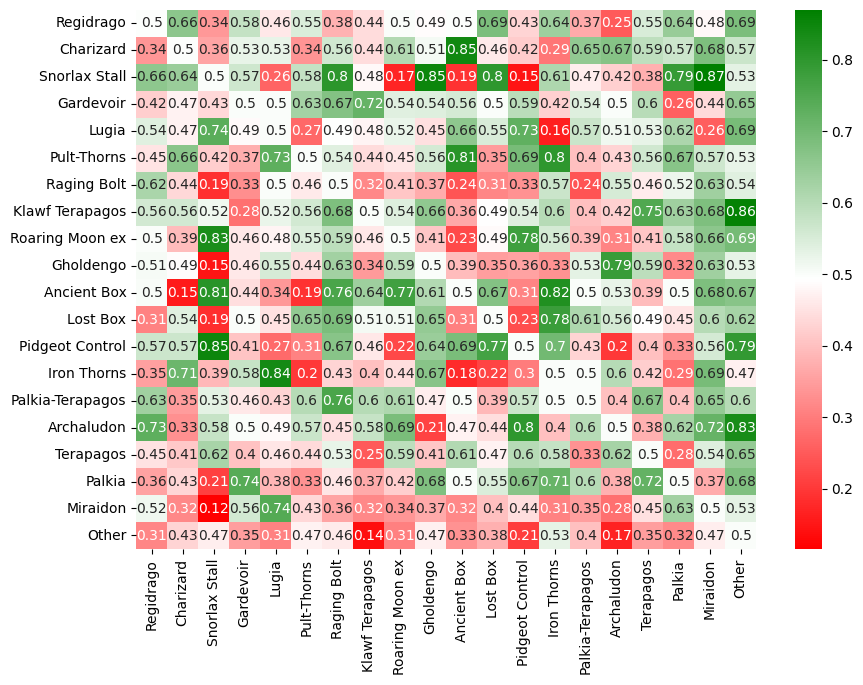

In [31]:
cmap = LinearSegmentedColormap.from_list("red_white_green", ["red", "white", "green"])

df_cm = pd.DataFrame(chart, index = my_decks,
                  columns = my_decks)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm,cmap=cmap, annot=True)

### Expected Value

In [37]:

shares = [deck_stats[deck_stats['Name']==deck].Share.iloc[0] for deck in my_decks[:-1]]
shares.append(1-sum(shares))
print(shares)


[0.11976343026121242, 0.10612781337276163, 0.02792837194020043, 0.04912107770658781, 0.037292590767208804, 0.02168555938886151, 0.08559224576967307, 0.028914079185148676, 0.03532117627731231, 0.05536389025792673, 0.02480696566453097, 0.052571053063906685, 0.012814194184327254, 0.016264169541646133, 0.009035649745358962, 0.019221291276490884, 0.029899786430096928, 0.014785608674223755, 0.05634959750287498, 0.19714144898965014]


In [39]:
for i in range(len(my_decks)):
    ev = sum(chart[i] * shares)
    print(f'{my_decks[i]:<20} {ev:.3f}')

Regidrago            0.548
Charizard            0.518
Snorlax Stall        0.595
Gardevoir            0.541
Lugia                0.531
Pult-Thorns          0.533
Raging Bolt          0.469
Klawf Terapagos      0.618
Roaring Moon ex      0.536
Gholdengo            0.502
Ancient Box          0.551
Lost Box             0.526
Pidgeot Control      0.590
Iron Thorns          0.485
Palkia-Terapagos     0.550
Archaludon           0.577
Terapagos            0.507
Palkia               0.512
Miraidon             0.440
Other                0.402


### Counts

In [58]:
n= len(my_decks)
chart = np.full((n, n), 0)
games=0
for i in range(len(my_decks)):
    for j in range(len(my_decks)):
        if my_decks[j] in matchups[my_decks[i]]:
            matchup = matchups[my_decks[i]][my_decks[j]]
            chart[i][j] = int(matchup['W']+matchup['L']+matchup['T'])
        else:
            chart[i][j] = 0
        # if i==j:
        #     chart[i][j] = int(chart[i][j]/2)

<Axes: >

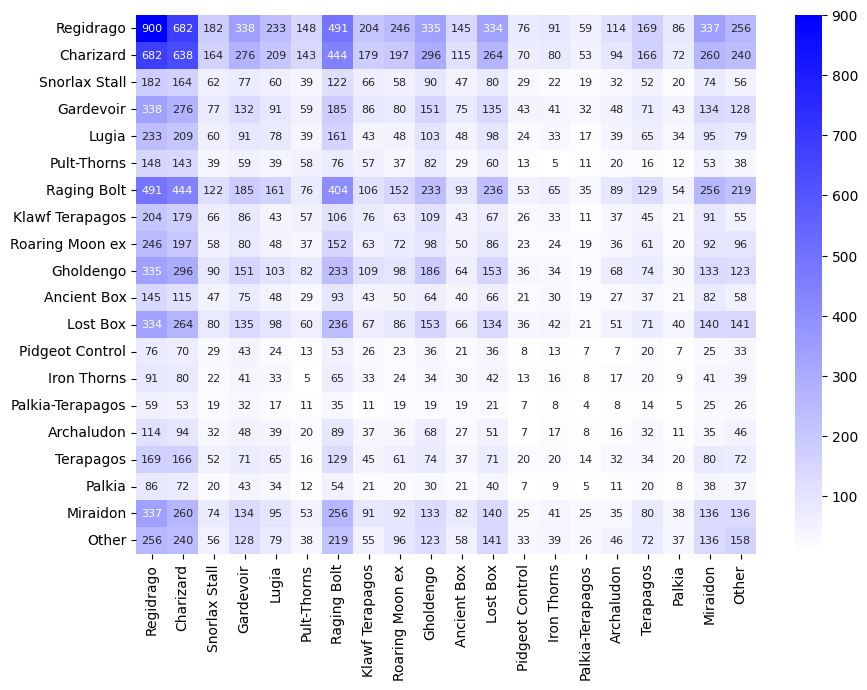

In [59]:
cmap = LinearSegmentedColormap.from_list("white-blue", ["white", "blue"])

df_cm = pd.DataFrame(chart, index = my_decks,
                  columns = my_decks)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm,fmt="d",cmap=cmap,annot_kws={"size": 8},annot=True)

In [60]:
np.sum(chart)/2

18602.0

### Next steps
- Run EVs against day 1 and 2 of all the tournaments
- Compare match point charts to non-match point charts
- Test change in winrates as better players are selected against
- Run actual tournament sim with evs

### Misc

In [34]:
deck_stats

,Name,Count,Share
0,Regidrago,729,0.119763
1,Charizard,646,0.106128
2,Raging Bolt,521,0.085592
3,Miraidon,343,0.056350
4,Gholdengo,337,0.055364
5,Other,324,0.053228
6,Lost Box,320,0.052571
7,Gardevoir,299,0.049121
8,UNKNOWN,271,0.044521
9,Lugia,227,0.037293


In [ ]:
matchups['Palkia-Terapagos']

In [ ]:
day_2_players_df.iloc[0]

In [ ]:
players_df['Name'].value_counts()

In [ ]:
deck_stats[deck_stats['Name']=='Regidrago'].Share[0]

In [ ]:
players[2000]

In [ ]:
count=0
ties=0
for i in matchups.keys():
    for j in matchups[i].keys():
        count+=matchups[i][j]['count']
        ties+=matchups[i][j]['T']

In [ ]:
count/2

In [ ]:
ties/2

In [ ]:
ties/count

In [ ]:
players[0]['rounds']